In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

#Import standard pydata libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
filename = 'facies_PE_ET.csv'
training_data = pd.read_csv(filename)
#training_data['Well Name'] = training_data['Well Name'].astype('category')
#training_data['Formation'] = training_data['Formation'].astype('category')
training_data['train'] = 1
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.0
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.761512,1.518438,0.521852,1.0
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.839810,0.499720,0.286644,0.0
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,1.0
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,1.0
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000,1.0
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,1.0
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,1.0


In [ ]:
validation_data = pd.read_csv("validation_data_nofacies.csv")
#validation_data['Well Name'] = validation_data['Well Name'].astype('category')
#validation_data['Formation'] = validation_data['Formation'].astype('category')
validation_data['train'] = 0
validation_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.0
mean,2986.669375,57.462969,0.666691,2.870725,11.593350,3.666061,1.682500,0.538704,0.0
std,95.071746,27.825792,0.290018,3.381865,5.192669,0.647622,0.465795,0.282750,0.0
min,2808.000000,12.036000,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,0.0
25%,2909.875000,36.223250,0.541750,0.443750,7.637500,3.185500,1.000000,0.309000,0.0
50%,2993.500000,57.957500,0.676000,2.400000,10.825000,3.532500,2.000000,0.550000,0.0
75%,3057.125000,73.022500,0.852000,4.612500,14.675000,4.201500,2.000000,0.778000,0.0
max,3160.500000,220.413000,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,0.0


In [ ]:
all_data = training_data.append(validation_data)
all_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
0,3.0,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,1
1,3.0,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,1
2,3.0,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,1
3,3.0,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,1
4,3.0,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,1
...,...,...,...,...,...,...,...,...,...,...,...,...
795,NaN,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,0
796,NaN,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,0
797,NaN,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,0
798,NaN,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,0


In [ ]:
avg_PE_facies = training_data[['Facies', 'PE']].groupby('Facies').mean()
avg_PE_facies = avg_PE_facies.to_dict()
all_data['PE2'] = all_data.Facies.map(avg_PE_facies['PE'])

In [ ]:
dfs = []
for well in all_data['Well Name'].unique():
    df = all_data[all_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = df[col].rolling(10).mean()
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
all_data = pd.concat(dfs)
pe_mean = all_data.PE.mean()
sm_pe_mean = all_data.smooth_PE.mean()
all_data['PE'] = all_data.PE.replace({np.nan:pe_mean})
all_data['smooth_PE'] = all_data['smooth_PE'].replace({np.nan:sm_pe_mean})
formation_encoder = dict(zip(all_data.Formation.unique(), range(len(all_data.Formation.unique()))))
all_data['enc_formation'] = all_data.Formation.map(formation_encoder)


In [ ]:
def to_binary_vec(value, vec_length):
    vec = np.zeros(vec_length)
    vec[value] = 1
    return vec

In [ ]:
dfs = list()
for well in all_data['Well Name'].unique():
    tmp_df = all_data[all_data['Well Name'] == well].copy(deep=True)
    tmp_df.sort_values('Depth', inplace=True)
    for feature in ['Depth', 'ILD_log10', 'DeltaPHI', 'PHIND', 'smooth_PE', 'smooth_GR']:
        tmp_df['3prev_'+feature] = tmp_df[feature] / tmp_df[feature].shift(4)
        #tmp_df['2prev_'+feature] = tmp_df[feature] / tmp_df[feature].shift(-1)
        
        tmp_df['3prev_'+feature].fillna(method='bfill', inplace=True)
        #tmp_df['2prev_'+feature].fillna(method='ffill', inplace=True)
    
        tmp_df['3prev_'+feature].replace([np.inf, -np.inf], 0, inplace=True)
        #tmp_df['2prev_'+feature].replace([np.inf, -np.inf], 0, inplace=True)
        
    tmp_df['3prev_enc'] = tmp_df['enc_formation'].shift(3).fillna(method='bfill')
    tmp_df['2prev_enc'] = tmp_df['enc_formation'].shift(2).fillna(method='bfill')
    dfs.append(tmp_df)
all_data = pd.concat(dfs)

In [ ]:
all_data.columns


Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'train', 'PE2',
       'smooth_PE', 'smooth_GR', 'enc_formation', '3prev_Depth',
       '3prev_ILD_log10', '3prev_DeltaPHI', '3prev_PHIND', '3prev_smooth_PE',
       '3prev_smooth_GR', '3prev_enc', '2prev_enc'],
      dtype='object')

In [ ]:
#Let's build a model
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from classification_utilities import display_cm
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
#We will take a look at an F1 score for each well
estimators=200
learning_rate=.01
random_state=0
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

title_length = 20 

training_data = all_data[all_data.train==1]
scores = list()

wells = training_data['Well Name'].unique()
for well in wells:
    blind = training_data[training_data['Well Name']==well]
    train = training_data[(training_data['Well Name']!=well)]
    
    train_X = train.drop(['Formation', 'Well Name', 'Facies', 'Depth', 'PE2', 'train'], axis=1)
    train_Y = train.Facies.values
    test_X = blind.drop(['Formation', 'Well Name', 'Facies', 'Depth', 'PE2', 'train'], axis=1)
    test_Y = blind.Facies.values
    
    clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=200), n_estimators=200, learning_rate=learning_rate, random_state=random_state, algorithm='SAMME.R')
    
    clf.fit(train_X,train_Y)
    print(clf.feature_importances_)
    pred_Y = clf.predict(test_X)
    f1 = metrics.f1_score(test_Y, pred_Y, average='micro')
    scores.append(f1)
    print("*"*title_length)
    print("{well}={f1:.4f}".format(well=well,f1=f1))
    print("*"*title_length)
print("Avg F1: {score}".format(score=sum(scores)/len(scores)))


[0.07603794 0.07253465 0.04885564 0.07845103 0.08273077 0.09121821
 0.06394708 0.07334164 0.06020622 0.02638137 0.06618673 0.04290839
 0.03577774 0.03668717 0.05189534 0.04303731 0.0244548  0.02534797]
********************
SHRIMPLIN=0.5902
********************
[0.08001883 0.07702886 0.04945832 0.07565319 0.07750446 0.09196086
 0.06182998 0.06609107 0.05911327 0.03071911 0.07280297 0.04098592
 0.03475372 0.03660995 0.04800508 0.04021446 0.02877314 0.02847682]
********************
ALEXANDER D=0.6116
********************
[0.07805201 0.07813485 0.04947978 0.07514495 0.0754004  0.10066287
 0.06812029 0.06748989 0.0569529  0.02636852 0.06936672 0.0408051
 0.03577885 0.03636637 0.04921205 0.04147853 0.0265024  0.02468352]
********************
SHANKLE=0.4521
********************
[0.080724   0.07042609 0.05106908 0.07575169 0.07814034 0.09074798
 0.0646157  0.06981331 0.05989532 0.02999448 0.081083   0.04010586
 0.03404123 0.03574795 0.04645442 0.03948186 0.02584289 0.02606482]
****************

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(training_data.drop(['Formation', 'Well Name','Facies', 'Depth', 'PE2', 'train'], axis=1), training_data.Facies.values, test_size=.2)


In [ ]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3319, 18)
(3319,)
(830, 18)
(830,)


In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy(cm):
    total_correct = 0.
    nb_classes = cm.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
    acc = total_correct/sum(sum(cm))
    return acc

def accuracy_adjacent(cm, adjacent_facies):
    nb_classes = cm.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
        for j in adjacent_facies[i]:
            total_correct += cm[i][j]
    return total_correct / sum(sum(cm))

In [ ]:
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=estimators), n_estimators=estimators, random_state=0,learning_rate=learning_rate, algorithm='SAMME.R')
clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
cm = metrics.confusion_matrix(y_true=test_Y, y_pred=pred_Y)
display_cm(cm, facies_labels, display_metrics=True)

     Pred
            SS
          CSiS
          FSiS
          SiSh
            MS
            WS
             D
            PS
            BS
         Total
     True
            SS
            47
             5
              
              
              
              
              
              
              
            52
          CSiS
             1
           166
            11
              
              
             1
              
             1
              
           180
          FSiS
              
            23
           132
              
              
             1
              
             1
              
           157
          SiSh
              
              
             1
            48
             2
             4
             1
              
              
            56
            MS
              
              
             2
             1
            36
            12
              
            10
              
            61
     

In [ ]:
print ('Facies classification accuracy = %f' % accuracy(cm))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(cm, adjacent_facies))

Facies classification accuracy = 0.830120
Adjacent facies classification accuracy = 0.955422


Text(0.5, 1.0, 'Confusion Matrix')

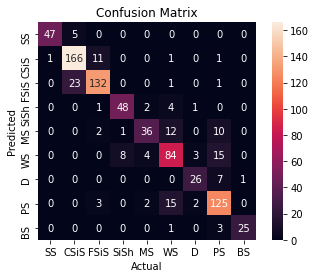

In [ ]:
axes = sns.heatmap(cm,annot=True, fmt="d",square=True, cbar=True, xticklabels= facies_labels, yticklabels= facies_labels)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.set_title('Confusion Matrix')

In [ ]:
validation_data = all_data[all_data.train==0]


In [ ]:
validation_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train,PE2,smooth_PE,smooth_GR,enc_formation,3prev_Depth,3prev_ILD_log10,3prev_DeltaPHI,3prev_PHIND,3prev_smooth_PE,3prev_smooth_GR,3prev_enc,2prev_enc
count,0.0,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.0,0.0,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,NaN,2986.669375,57.462969,0.666691,2.870725,11.593350,3.666061,1.682500,0.538704,0.0,NaN,3.667989,57.195936,6.246250,1.000712,0.937335,0.182971,1.145832,1.003790,1.035531,6.156250,6.186250
std,NaN,95.071746,27.825792,0.290018,3.381865,5.192669,0.647622,0.465795,0.282750,0.0,NaN,0.527352,23.013495,4.599136,0.000257,3.797023,17.547204,0.705276,0.091701,0.254606,4.593279,4.595428
min,NaN,2808.000000,12.036000,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,0.0,NaN,2.359800,16.646700,0.000000,1.000633,-103.000000,-337.500000,0.205227,0.797511,0.500112,0.000000,0.000000
25%,NaN,2909.875000,36.223250,0.541750,0.443750,7.637500,3.185500,1.000000,0.309000,0.0,NaN,3.292975,38.263275,1.000000,1.000655,0.861974,0.130425,0.775790,0.943651,0.890991,1.000000,1.000000
50%,NaN,2993.500000,57.957500,0.676000,2.400000,10.825000,3.532500,2.000000,0.550000,0.0,NaN,3.596400,57.147450,5.000000,1.000670,0.981033,0.776738,0.999841,0.997681,1.012033,5.000000,5.000000
75%,NaN,3057.125000,73.022500,0.852000,4.612500,14.675000,4.201500,2.000000,0.778000,0.0,NaN,4.064375,71.859875,11.000000,1.000696,1.144406,1.460742,1.267743,1.046050,1.156217,11.000000,11.000000
max,NaN,3160.500000,220.413000,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,0.0,NaN,5.292900,151.488400,13.000000,1.003972,13.100000,79.700000,6.483146,1.294929,2.004543,13.000000,13.000000


In [ ]:
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies', 'train', 'PE2'], axis=1)
Y = training_data.Facies.values
test_X = validation_data.drop(['Formation', 'Well Name', 'Depth', 'train', 'PE2', 'Facies'], axis=1)

clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=estimators), n_estimators=estimators, learning_rate=learning_rate, random_state=0)
clf.fit(X,Y)
predicted_facies = clf.predict(test_X)
validation_data['Facies'] = predicted_facies

In [ ]:
validation_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train,PE2,smooth_PE,smooth_GR,enc_formation,3prev_Depth,3prev_ILD_log10,3prev_DeltaPHI,3prev_PHIND,3prev_smooth_PE,3prev_smooth_GR,3prev_enc,2prev_enc
0,2.0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,0,NaN,3.1542,78.6464,0,1.000712,1.012698,2.636364,1.159624,1.000000,1.000000,0.0,0.0
1,3.0,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,0,NaN,3.1542,78.6464,0,1.000712,1.012698,2.636364,1.159624,1.000000,1.000000,0.0,0.0
2,3.0,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,0,NaN,3.1542,78.6464,0,1.000712,1.012698,2.636364,1.159624,1.000000,1.000000,0.0,0.0
3,3.0,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,0,NaN,3.1542,78.6464,0,1.000712,1.012698,2.636364,1.159624,1.000000,1.000000,0.0,0.0
4,3.0,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,0,NaN,3.1542,78.6464,0,1.000712,1.012698,2.636364,1.159624,1.000000,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2.0,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,0,NaN,3.5363,71.8486,12,1.000634,0.911184,1.390345,1.264188,1.038805,1.010822,12.0,12.0
796,2.0,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,0,NaN,3.5199,73.9871,12,1.000634,0.890909,1.342995,1.248137,1.024388,1.045038,12.0,12.0
797,2.0,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,0,NaN,3.4725,77.1529,12,1.000633,0.889262,1.304615,1.213743,0.999079,1.093397,12.0,12.0
798,2.0,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,0,NaN,3.3986,80.4558,12,1.000633,0.904679,1.343840,1.144830,0.966307,1.135918,12.0,12.0


In [ ]:
validation_data.to_csv("Adaptive_Boosting.csv", index=False)
